In [2]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w',
         'font.family': 'serif'} 
plt.rcParams.update(params)

### This notebook is for calculating the redshift completeness and the catastrophic failure rate of galaxies, including BGS, LRGs, and ELGs.

Definition -

Assumption: The truth tables are complete and correct for all objects with z(true).
That’s a reasonable approximation for all target classes except ELGs.

If you’re using DELTACHI2>cut to define wether a redshift is conclusive
in a 1000 sec exposure, then:

a = LRGs with 0.3 < z(true) <1.4, DELTACHI2>cut, and z_Redrock = z(true)

b = LRGs with 0.3 < z(true) <1.4, DELTACHI2<cut, and z(true)<1.4

c = LRGs with 0.3 < z(true) <1.4, DELTACHI2>cut, and |z_Redrock - z(true)| > 1000 km/s

### Redshift completeness = $\frac{a}{a+b+c}$

### catastrophic failure rate = $\frac{c}{a+b+c}$


In [128]:
def get_deep_and_short_catalog(catalog, object_type):
    if object_type=='LRG':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['EFFTIME_DARK']>3000) &
                               (catalog['TARGETS']!='BGS+MWS'))        
    
        search_short = np.where((catalog['subset']!='all') & 
                                (catalog['subset']!='deep') & 
                                #(catalog['RZR']=='N') & 
                                (catalog['TARGETS']!='BGS+MWS') & 
                                #(catalog['EFFTIME_DARK']>3000)
                                (catalog['EFFTIME_DARK']>850) & 
                                (catalog['EFFTIME_DARK']<950)
                               )
    elif object_type=='LRG_VI':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['N_VI']>0) &
                               (catalog['TARGETS']!='BGS+MWS'))        
    
        search_short = np.where((catalog['subset']!='all') & 
                                (catalog['subset']!='deep') & 
                                (catalog['TARGETS']!='BGS+MWS') & 
                                (catalog['TARGETS']!='BGS+MWS') & 
                                #(catalog['EFFTIME_DARK']>3000))
                                (catalog['EFFTIME_DARK']>850) & 
                                (catalog['EFFTIME_DARK']<950))
    elif object_type=='BGS':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['EFFTIME_BRIGHT']>600))        
    
        search_short = np.where((catalog['subset']!='all') & 
                                #(catalog['RZR']=='single_exposures') & 
                                (catalog['subset']=='deep') & 
                                
                                (catalog['EFFTIME_BRIGHT']>600))# & 
                                #(catalog['EFFTIME_BRIGHT']<200))
    elif object_type=='BGS_VI':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['N_VI']>0))
                                       
    
        search_short = np.where((catalog['subset']!='all') & 
                                (catalog['subset']!='deep') & 
                                (catalog['N_VI']>0) &
                                (catalog['EFFTIME_BRIGHT']>100) & 
                                (catalog['EFFTIME_BRIGHT']<150))        
    elif object_type=='ELG':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['EFFTIME_DARK']>3000))        
    
        search_short = np.where((catalog['subset']!='all') & 
                                (catalog['subset']=='deep') & 
                                (catalog['EFFTIME_DARK']>3000) & 
                                #(catalog['EFFTIME_DARK']<950) & 
                                #((catalog['TARGETS']=='ELG') | 
                                (catalog['TARGETS']=='ELG') & 
                                (catalog['TARGET_DEC']>32.5) &
                                (catalog['TARGET_DEC']>-20))      
    elif object_type=='ELG_VI':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['vi_hasvi']==True))        
    
        search_short = np.where((catalog['subset']!='all') & 
                                (catalog['subset']!='deep') & 
                                (catalog['EFFTIME_DARK']>850) & 
                                (catalog['EFFTIME_DARK']<950) & (catalog['vi_hasvi']==True))          
    catalog_short = catalog[search_short[0]].copy()
    catalog_deep = catalog[search_deep[0]].copy()
    print('Number of spectra in deep:', len(catalog_deep))
    print('Number of spectra in short:', len(catalog_short))
    return catalog_deep, catalog_short

In [136]:
def matching_short_deep_information(catalog_deep, catalog_short,object_type):
    if object_type=='LRG':
        new_catalog_short = catalog_short[['TARGETID','Z','TARGET_DEC','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','TARGET_DEC','DELTACHI2','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['best_z']=new_catalog['Z']
        new_catalog['best_quality']=0
        new_catalog['best_quality'][(new_catalog['best_z']<1.4)  & (new_catalog['DELTACHI2']>15)]=4
        # here I assign LRG with z<1.4 and DELTACHI2>30 from the deep exposure as reliable
        new_catalog_short['d']=(10**(3 - 3.5*new_catalog_short['Z']))
    elif object_type=='LRG_VI':
        new_catalog_short = catalog_short[['TARGETID','Z','TARGET_DEC','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','best_quality','best_z'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog_short['d']=(10**(3 - 3.5*new_catalog_short['Z']))

        #new_catalog['best_z']=new_catalog['Z']
        #new_catalog['best_quality']=0
        #new_catalog['best_quality'][(new_catalog['best_quality']>=2.5)]=4
        # here I assign LRG with z<1.4 and DELTACHI2>30 from the deep exposure as reliable

    elif object_type=='BGS':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','SPECTYPE'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['rfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['color']=(new_catalog['zmag']-new_catalog['w1mag'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
        new_catalog['best_z']=new_catalog['Z']
        new_catalog['best_quality']=0
        new_catalog['best_spectype']=new_catalog['SPECTYPE']
        new_catalog['best_quality'][(new_catalog['best_z']<1.1)  & (new_catalog['DELTACHI2']>40)]=4
        # here I assign BGS with z<1.1 and DELTACHI2>15 from the deep exposure as reliable
    elif object_type=='BGS_VI':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','SPECTYPE','best_quality','best_z','best_spectype','all_VI_comments'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['rfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['color']=(new_catalog['zmag']-new_catalog['w1mag'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
        #new_catalog['best_z']=new_catalog['Z']
        #new_catalog['best_quality']=0
        #new_catalog['best_quality'][(new_catalog['best_z']<1.1)  & (new_catalog['DELTACHI2']>40)]=4
    elif object_type=='ELG':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER','FOII','FOII_ERR','GTOT','GFIB','RZ','GR']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','SPECTYPE','FOII','FOII_ERR'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['rfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['color']=(new_catalog['zmag']-new_catalog['w1mag'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
        new_catalog['best_z']=new_catalog['Z']
        new_catalog['OII_SN']=new_catalog['FOII']/new_catalog['FOII_ERR']
        new_catalog['best_quality']=0
        new_catalog['best_quality'][(new_catalog['best_z']<1.58) & (new_catalog['best_z']>0.6) & 
                                    (np.log10(new_catalog['OII_SN'])>(0.9-0.2*np.log10(new_catalog['DELTACHI2']))) & (new_catalog['FOII']>0)]=4
        new_catalog['best_quality'][(new_catalog['best_z']<0.6) & (new_catalog['DELTACHI2']>50)
                                    ]=4
        new_catalog['best_quality'][(new_catalog['best_z']>1.58) & (new_catalog['best_z']<3.5) & (new_catalog['DELTACHI2']>50)
                                    ]=4

        new_catalog_short['OII_SN']=new_catalog_short['FOII']/new_catalog_short['FOII_ERR']

    elif object_type=='ELG_VI':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER','FOII','FOII_ERR','GTOT','GFIB','RZ','GR']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','SPECTYPE','FOII','FOII_ERR','vi_best_quality','vi_best_z'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['rfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['color']=(new_catalog['zmag']-new_catalog['w1mag'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
        new_catalog['best_z']=new_catalog['vi_best_z']
        new_catalog['OII_SN']=new_catalog['FOII']/new_catalog['FOII_ERR']
        new_catalog['best_quality']=new_catalog['vi_best_quality']
        #new_catalog['best_quality'][(new_catalog['best_z']<1.6) & 
        #                            (np.log10(new_catalog['OII_SN'])>(0.9-0.2*np.log10(new_catalog['DELTACHI2']))) & (new_catalog['FOII']>0)]=4
        new_catalog_short['OII_SN']=new_catalog_short['FOII']/new_catalog_short['FOII_ERR']
        
    catalog_match = new_catalog_short.merge(new_catalog,on='TARGETID',how='left',suffixes=("","_deep"))
    final_match_catalog = catalog_match[catalog_match['TILEID_deep']==catalog_match['TILEID']]
    final_match_catalog['dz']=abs(final_match_catalog['best_z']-final_match_catalog['Z'])/(1.+final_match_catalog['best_z'])
    print('Number of spectra in the matched catalog:',len(final_match_catalog))
    return final_match_catalog    

In [111]:
def calculating_redshift_completeness_and_failure_rate(input_catalog,object_type,verbose=False):
    if (object_type=='LRG') | (object_type=='LRG_VI'):

        DELTACHI2_limit = 15

        a = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']<0.0033) &
            (input_catalog['best_quality']>=2.5)
            )

        b = ((input_catalog['DELTACHI2']<DELTACHI2_limit) #& (catalog['best_quality']==4)
            )

        c = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']>0.0033) &
            (input_catalog['best_quality']>=2.5)
            )

        d = ((input_catalog['DELTACHI2']>DELTACHI2_limit) &
            (input_catalog['best_quality']<2.5)
            )

    elif (object_type=='BGS') | (object_type=='BGS_VI'):

        DELTACHI2_limit = 40

        a = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']<0.0033) & 
            (input_catalog['best_quality']>=2.5))

        b = ((input_catalog['DELTACHI2']<DELTACHI2_limit) #& (catalog['best_quality']==4)
            )

        c = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']>0.0033) & 
            (input_catalog['best_quality']>=2.5))

        d = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['best_quality']<2.5))

    elif (object_type=='ELG') | (object_type=='ELG_VI'):

        

        a = ((np.log10(input_catalog['OII_SN'])>(0.9-0.2*np.log10(input_catalog['DELTACHI2']))) & 
            (input_catalog['FOII']>0) &
            (input_catalog['dz']<0.0033) & 
            (input_catalog['best_quality']>=2.5)
            )

        b = (#(np.log10(catalog['OII_SN'])<(0.6)) |
            #(input_catalog['best_quality']>=2.5) &
            ((np.log10(input_catalog['OII_SN'])<(0.9-0.2*np.log10(input_catalog['DELTACHI2'])))) | 
             (input_catalog['FOII']<0))#& (catalog['best_quality']==4)
            

        c = (#(np.log10(catalog['OII_SN'])>(0.6)) &
            (np.log10(input_catalog['OII_SN'])>(0.9-0.2*np.log10(input_catalog['DELTACHI2']))) & 
            (input_catalog['FOII']>0) &
            (input_catalog['dz']>0.0033) & 
            (input_catalog['best_quality']>=2.5)
            )

        d = (#(np.log10(catalog['OII_SN'])>(0.6)) &
            (np.log10(input_catalog['OII_SN'])>(0.9-0.2*np.log10(input_catalog['DELTACHI2']))) & 
            (input_catalog['FOII']>0) & 
            (input_catalog['best_quality']<2.5))
                 
    N_a = len(input_catalog[a])
    N_b = len(input_catalog[b])
    N_c = len(input_catalog[c])
    N_all = len(input_catalog)
    N_d = len(input_catalog[d])
    if N_all!=0:
        redshift_completeness = N_a*1.0 / (N_a+N_b+N_c)
        failure_rate = N_c*1.0 / (N_a+N_b+N_c)
        redshift_completeness = N_a*1.0 / N_all
        failure_rate = (N_c*1.0+N_d*1.0) / N_all
    else:    
        redshift_completeness=None
        failure_rate=None
    if verbose==True:
        print(N_a,N_b,N_c,N_d,N_all)
        print(redshift_completeness,failure_rate)
    #print(input_catalog[c])
    #redshift_completeness = N_a*1.0 / N_all
    #failure_rate = N_c*1.0 / N_all
    #print('Redshift completeness, catastrophic failure rate:',redshift_completeness,failure_rate)
    return redshift_completeness,failure_rate

In [112]:
def give_me_a_b_c_d(input_catalog,object_type,verbose=False):
    
   
    if (object_type=='LRG') | (object_type=='LRG_VI'):
        #d = (10**(3 - 3.5*input_catalog['Z']))

        DELTACHI2_limit = 30
        
        a = ((((input_catalog['d']>30) & (input_catalog['DELTACHI2']>30)) | ((input_catalog['d']<30) & (input_catalog['DELTACHI2']>input_catalog['d']))) &
            ((input_catalog['DELTACHI2']>10) & 
            (input_catalog['dz']<0.0033) &
            (input_catalog['best_quality']>=2.5))
            )

        b = ((input_catalog['DELTACHI2']<DELTACHI2_limit) #& (catalog['best_quality']==4)
            )

        c = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']>0.0033) &
            (input_catalog['best_quality']>=2.5)
            )

        d = ((input_catalog['DELTACHI2']>DELTACHI2_limit) &
            (input_catalog['best_quality']<2.5)
            )

    elif (object_type=='BGS') | (object_type=='BGS_VI'):

        DELTACHI2_limit = 40
    
        a = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']<0.0033) & 
            (input_catalog['best_quality']>=2.5))

        b = ((input_catalog['DELTACHI2']<DELTACHI2_limit) #& (catalog['best_quality']==4)
            )

        c = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['dz']>0.0033) & 
            (input_catalog['best_quality']>=2.5))

        d = ((input_catalog['DELTACHI2']>DELTACHI2_limit) & 
            (input_catalog['best_quality']<2.5))

    elif (object_type=='ELG') | (object_type=='ELG_VI'):

        low_z_catalog = input_catalog[input_catalog['best_z']<0.6]
        middle_z_catalog = input_catalog[(input_catalog['best_z']>0.6) & (input_catalog['best_z']<1.58)]
        high_z_catalog = input_catalog[(input_catalog['best_z']>1.58)]

        middle_a = ((np.log10(middle_z_catalog['OII_SN'])>(0.9-0.2*np.log10(middle_z_catalog['DELTACHI2']))) & 
                (middle_z_catalog['FOII']>0) &
                (middle_z_catalog['dz']<0.0033) & 
                (middle_z_catalog['best_quality']>=2.5)
                )

       
        
        low_a = ((low_z_catalog['DELTACHI2']>50) & 
                (low_z_catalog['dz']<0.0033) & 
                (low_z_catalog['best_quality']>=2.5)
                )



        high_a = ((high_z_catalog['DELTACHI2']>50) & 
            (high_z_catalog['dz']<0.0033) & 
            (high_z_catalog['best_quality']>=2.5)
            )

    if (object_type=='ELG') | (object_type=='ELG_VI'):                                   
        N_a = len(low_z_catalog[low_a])+len(middle_z_catalog[middle_a])+len(high_z_catalog[high_a])
    else:
        N_a = len(input_catalog[a])
    N_all = len(input_catalog)
  
    if N_all!=0:
        redshift_completeness = N_a*1.0 / N_all
        
    else:    
        redshift_completeness=None
        failure_rate=None
    if verbose==True:
        print(N_a,N_all)
       # print(redshift_completeness,failure_rate)
    #plt.scatter(input_catalog[a]['Z'],np.log10(input_catalog[a]['DELTACHI2']))
    #print(input_catalog[c])
    #redshift_completeness = N_a*1.0 / N_all
    #failure_rate = N_c*1.0 / N_all
    #print('Redshift completeness, catastrophic failure rate:',redshift_completeness,failure_rate)
    return {'a':N_a}

In [113]:
def getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog,mode,mag_bin,magnitude_name):
    redshift_completeness_all = []
    redshift_failure_rate_all = []
    average_bin = []
    for i in range(0,len(mag_bin)-1):
        average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
        if mode=='differential':
            input_catalog = base_line_catalog[(base_line_catalog[magnitude_name]>mag_bin[i]) & (base_line_catalog[magnitude_name]<mag_bin[i+1])]
        elif mode=='cumulative':
            input_catalog = base_line_catalog[(base_line_catalog[magnitude_name]>mag_bin[0]) & (base_line_catalog[magnitude_name]<mag_bin[i+1])]

        redshift_completeness_tmp,redshift_failure_tmp = calculating_redshift_completeness_and_failure_rate(input_catalog,object_type)
        redshift_completeness_all.append(redshift_completeness_tmp)
        redshift_failure_rate_all.append(redshift_failure_tmp)
    return average_bin, redshift_completeness_all, redshift_failure_rate_all   

In [114]:
def getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog,mode,z_bin,object_type):
    redshift_completeness_all = []
    redshift_failure_rate_all = []
    average_bin = []
    for i in range(0,len(z_bin)-1):
        average_bin.append((z_bin[i]+z_bin[i+1])/2.)
        if mode=='differential':
            input_catalog = base_line_catalog[(base_line_catalog['best_z']>z_bin[i]) & (base_line_catalog['best_z']<z_bin[i+1])]
        elif mode=='cumulative':
            input_catalog = base_line_catalog[(base_line_catalog['best_z']>z_bin[0]) & (base_line_catalog['best_z']<z_bin[i+1])]

        number_of_objects = give_me_a_b_c_d(input_catalog,object_type)
        redshift_completeness_all.append(number_of_objects['a']*1/len(base_line_catalog))
        #redshift_failure_rate_all.append(redshift_failure_tmp)
    return average_bin, redshift_completeness_all

In [115]:
def plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name):
    x,y,z = getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog,mode,mag_bin,magnitude_name)
    x,y_SV3,z_SV3 = getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog_SV3,mode,mag_bin,magnitude_name)
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(x,np.array(y),label='SV1')
    plt.plot(x,np.array(y_SV3),label='SV3')
    plt.title('Redshift completeness')
    plt.legend()
    plt.xlabel(magnitude_name)
    #plt.axvline(21.72,ls='--',color='grey')
    #plt.text(19,0.85,mode,fontsize=15)
    plt.ylabel('Fraction ('+mode+')')

    plt.subplot(1,2,2)
    plt.title('Catastrophic failure rate')
    plt.plot(x,np.array(z))
    plt.plot(x,np.array(z_SV3))
    #plt.axvline(21.72,ls='--',color='grey')
    plt.xlabel(magnitude_name)
    
    return {'x':x,'y':y,'z':z,'y_SV3':y_SV3,'z_SV3':z_SV3}

In [116]:
def plot_curve_VI_SV(SV_data,VI_data,magnitude_name,mode):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(SV_data['x'],np.array(SV_data['y']),label='SV1 selection',color='C0')
    plt.plot(SV_data['x'],np.array(SV_data['y_SV3']),label='SV3 selection',color='C1')
    plt.plot(VI_data['x'],np.array(VI_data['y']),ls='--',color='C0',label='SV1 selection (VI only)')
    plt.plot(VI_data['x'],np.array(VI_data['y_SV3']),ls='--',color='C1',label='SV3 selection (VI only)')
    plt.title('Redshift completeness')
   
    plt.xlabel(magnitude_name)
    #plt.axvline(21.72,ls='--',color='grey')
    #plt.text(19,0.85,mode,fontsize=15)
    if mode=='differential':
        plt.ylim(0.2,1.03)
        plt.legend()
    else:    
        plt.ylim(0.5,1.03)

    plt.ylabel('Fraction ('+mode+')')
    plt.xlim(0.6,1.6)
    plt.subplot(1,2,2)
    plt.title('Catastrophic failure rate')
    plt.plot(SV_data['x'],np.array(SV_data['z']),color='C0')
    plt.plot(SV_data['x'],np.array(SV_data['z_SV3']),color='C1')
    plt.plot(VI_data['x'],np.array(VI_data['z']),ls='--',color='C0')
    plt.plot(VI_data['x'],np.array(VI_data['z_SV3']),ls='--',color='C1')
    plt.ylim(-0.005,0.03)
    #plt.axvline(21.72,ls='--',color='grey')
    plt.xlabel(magnitude_name)
    plt.xlim(20,24.5)
    plt.xlim(0.6,1.6)

---------------------------------------------------------------------------------------------------
### LRGs


Using Cascades data release

In [140]:
object_type = 'LRG'
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
if object_type =='LRG':
    dataname = 'alltiles_LRGzinfo.fits'
elif object_type =='LRG_VI':    
    dataname = 'allVItiles_LRGzinfo_wVI.fits'
all_catalog = Table.read(diretory+dataname)
catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)

Number of spectra in deep: 24973
Number of spectra in short: 26045


In [141]:
final_catalog.columns

Index(['TARGETID', 'Z', 'TARGET_DEC', 'ZERR', 'TILEID', 'EFFTIME_DARK',
       'DELTACHI2', 'ZWARN', 'FIBER', 'd', 'Z_deep', 'TILEID_deep',
       'DELTACHI2_deep', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FLUX_W1', 'FLUX_R',
       'FLUX_Z', 'FLUX_G', 'EBV', 'ZWARN_deep', 'FIBER_deep', 'best_quality',
       'best_z', 'zmag', 'gmag', 'rmag', 'w1mag', 'zfibermag', 'dz'],
      dtype='object')

In [147]:

final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
# ---------------------
# cut the catalog with the interested parameter region  
# Baseline sample
# LRGs
#
#object_type='LRG'
selection = ((final_catalog['zfibermag']<21.6) &
             (final_catalog['TARGET_DEC']<32.5) &
             (final_catalog['best_z']<1.4) & 
             (final_catalog['Z']<1.4)
            ) 

base_line_catalog = final_catalog[selection]
SV3_selection = (((base_line_catalog['zmag']-base_line_catalog['w1mag'])>0.8*(base_line_catalog['rmag']-base_line_catalog['zmag'])-0.6) &
            ((((base_line_catalog['gmag']-base_line_catalog['rmag'])>1.34) & 
             (base_line_catalog['gmag']-base_line_catalog['rmag']>-1.55*(base_line_catalog['rmag']-base_line_catalog['w1mag'])+3.23)) |
            (base_line_catalog['rmag']-base_line_catalog['w1mag']>1.8)) &
            
             ((((base_line_catalog['rmag']-base_line_catalog['w1mag'])>(base_line_catalog['w1mag']-17.05)*1.83) & 
             ((base_line_catalog['rmag']-base_line_catalog['w1mag'])>(base_line_catalog['w1mag']-16.14))) |
            (base_line_catalog['rmag']-base_line_catalog['w1mag']>3.49))
            )


lrg_mask = base_line_catalog['zmag'] - base_line_catalog['w1mag'] > 0.8 * (base_line_catalog['rmag'] - base_line_catalog['zmag']) - 0.6  # non-stellar cu

lrg_mask_sliding = base_line_catalog['rmag'] - base_line_catalog['w1mag'] > (base_line_catalog['w1mag'] - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= base_line_catalog['rmag'] - base_line_catalog['w1mag'] > (base_line_catalog['w1mag'] - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= base_line_catalog['rmag'] - base_line_catalog['w1mag'] > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = base_line_catalog['gmag'] - base_line_catalog['w1mag'] > 2.9  # low-z cut
mask_lowz |= base_line_catalog['rmag'] - base_line_catalog['w1mag'] > 1.8  # low-z cut
lrg_mask &= mask_lowz


base_line_catalog_SV3 = base_line_catalog[lrg_mask]
print('Number of spectra in the baseline catalog:',len(base_line_catalog))
print('Number of spectra in the SV3 catalog:',len(base_line_catalog_SV3))

Number of spectra in the matched catalog: 24800
Number of spectra in the baseline catalog: 8877
Number of spectra in the SV3 catalog: 3758


In [148]:
d = (10**(3 - 3.5*base_line_catalog_SV3['Z']))

3677
80
1


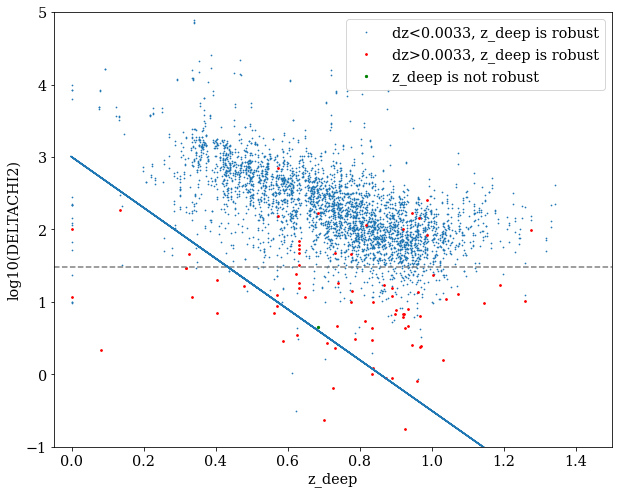

In [149]:
plt.figure(figsize=(10,8))
selection = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']<0.0033)
selection_2 = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']>0.0033) #& (base_line_catalog_SV3['DELTACHI2']>15)
selection_3 = (base_line_catalog_SV3['best_quality']<2.5)# & (base_line_catalog_SV3['dz']>0.0033)

plt.scatter(base_line_catalog_SV3['best_z'][selection],np.log10(base_line_catalog_SV3['DELTACHI2'][selection]),s=0.5,label="dz<0.0033, z_deep is robust")
                #c=base_line_catalog_SV3['zfibermag'][selection],vmin=19.0,vmax=21.5,)

plt.scatter(base_line_catalog_SV3['best_z'][selection_2],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_2]),s=3,label="dz>0.0033, z_deep is robust",color='r')
plt.scatter(base_line_catalog_SV3['best_z'][selection_3],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_3]),s=5,label="z_deep is not robust",color='g')
print(len(base_line_catalog_SV3[selection]))
print(len(base_line_catalog_SV3[selection_2]))
plt.legend()
plt.ylabel('log10(DELTACHI2)')
plt.xlabel('z_deep')
plt.axhline(np.log10(30),ls='--',color='grey')
print(len(base_line_catalog_SV3[selection_3]))
plt.xlim(-0.05,1.5)
plt.ylim(-1,5)
plt.plot(base_line_catalog_SV3['Z'],np.log10(d))


In [150]:
#give_me_a_b_c_d(base_line_catalog_SV3,'LRG')

1.1269
1.7709
8.8544
33.1639
62.6251
64.2350
75.1823
108.8292
98.0428
81.9439
32.6809
11.1083
3.7028
1.2879
0.0000


Text(0.5, 1.0, 'Deep_VI')

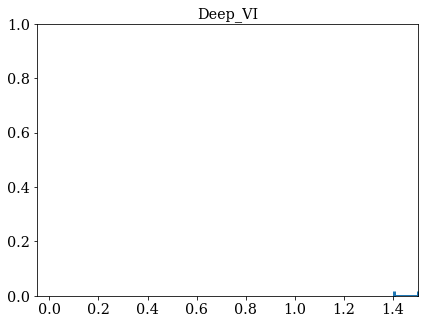

In [151]:
plt.figure(figsize=(15,5))
'''
mode='cumulative'
z_bin = np.arange(-0.003,,0.1)
z_bin[0]=0.003
#z_bin =[-0.1,0.4]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)
plt.subplot(1,2,1)
plt.plot(x,y)
print(y)
plt.ylim(0,1)
plt.xlim(-0.05,1.5)
'''
plt.subplot(1,2,2)
mode='differential'
z_bin = np.arange(0.003,1.51,0.1)
#z_bin[0]=-0.003
#z_bin = [-0.003,0.001,0.4,1.1,1.5]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)
y = np.array(y)*605
xerr = np.array(x)-z_bin[0:-1]
plt.errorbar(x,np.array(y)*1.0,xerr=xerr,ls='',capsize=5,mew=3,lw=3)
for i in range(0,len(x)):
    #plt.text(x[i]-0.05,y[i]+0.05,'%0.2f' % y[i])
    print('%0.4f' % y[i])
plt.ylim(-0,1)
plt.xlim(-0.05,1.5)
plt.title('Deep_VI')

In [61]:
np.array(y)*605

array([  1.2890625,   2.0625   ,   8.25     ,  31.7109375,  54.484375 ,
        68.8359375,  79.6640625, 111.03125  ,  97.8828125,  71.7578125,
        28.53125  ,  11.0859375,   3.3515625,   1.375    ,   0.       ])

In [521]:
1-np.sum(y)

0.002318943988583677

zfibermag<21.72

a = LRGs with 0.3 < z(true) <1.1, DELTACHI2>cut, and z_Redrock = z(true)

b = LRGs with 0.3 < z(true) <1.1, DELTACHI2<cut, and z(true)<1.4

c = LRGs with 0.3 < z(true) <1.1, DELTACHI2>cut, and |z_Redrock - z(true)| > 1000 km/s

### Redshift completeness = $\frac{a}{a+b+c}$

### catastrophic failure rate = $\frac{c}{a+b+c}$

In [59]:
calculating_redshift_completeness_and_failure_rate(base_line_catalog,object_type,True)
calculating_redshift_completeness_and_failure_rate(base_line_catalog_SV3,object_type,True)

16854 831 183 14 17882
0.942512023263617 0.011016664802594788
5880 342 71 4 6297
0.9337779895188185 0.011910433539780848


(0.9337779895188185, 0.011910433539780848)

-------------------------------------------------------------------
### BGS

In [546]:
object_type ='BGS'
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
if object_type =='BGS':
    dataname = 'alltiles_BGS_ANYzinfo.fits'
elif object_type =='BGS_VI':    
    dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'

#diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
#dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
all_catalog = Table.read(diretory+dataname)
catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)

Number of spectra in deep: 62967
Number of spectra in short: 62967


In [547]:
final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
# ---------------------
# cut the catalog with the interested parameter region  
# Baseline sample
# BGS
#
#object_type='BGS'
selection = ((final_catalog['rfibermag']<21.5) &
             (final_catalog['rmag']<19.5) &
             #(final_catalog['best_spectype']!=b'STAR') & 
             #(final_catalog['best_z']>0.0003) &
             (final_catalog['best_z']<1.1) & 
             (final_catalog['Z']<1.1)
            ) 

base_line_catalog = final_catalog[selection]
SV3_selection = (((base_line_catalog['rfibermag']<20.75) & (base_line_catalog['color']<0)) | 
     ((base_line_catalog['rfibermag']<21.5) & (base_line_catalog['color']>=0)))

base_line_catalog_SV3 = base_line_catalog[SV3_selection]
print('Number of spectra in the baseline catalog:',len(base_line_catalog))

Number of spectra in the matched catalog: 62967
Number of spectra in the baseline catalog: 23975


In [548]:
calculating_redshift_completeness_and_failure_rate(base_line_catalog,object_type,True)
calculating_redshift_completeness_and_failure_rate(base_line_catalog_SV3,object_type,True)

23902 73 0 0 23975
0.9969551616266945 0.0
22301 38 0 0 22339
0.99829893907516 0.0


(0.99829893907516, 0.0)

22301
0
38


(-1.0, 5.0)

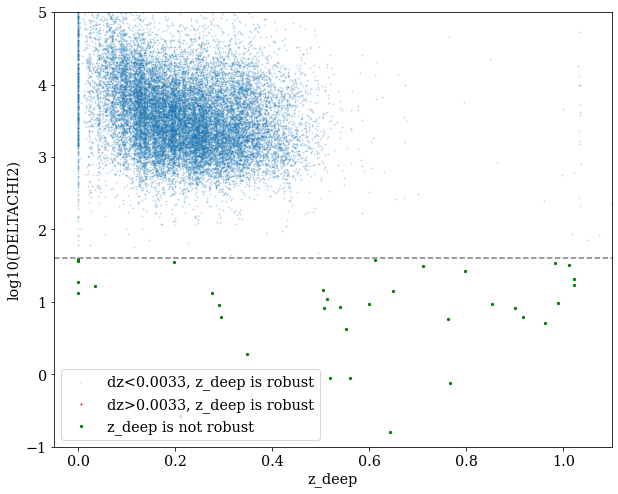

In [549]:
plt.figure(figsize=(10,8))
selection = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']<0.0033)
selection_2 = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']>0.0033) #& (base_line_catalog_SV3['DELTACHI2']>15)
selection_3 = (base_line_catalog_SV3['best_quality']<2.5)# & (base_line_catalog_SV3['dz']>0.0033)

plt.scatter(base_line_catalog_SV3['best_z'][selection],np.log10(base_line_catalog_SV3['DELTACHI2'][selection]),s=1,label="dz<0.0033, z_deep is robust",alpha=0.2)
                #c=base_line_catalog_SV3['zfibermag'][selection],vmin=19.0,vmax=21.5,)

plt.scatter(base_line_catalog_SV3['best_z'][selection_2],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_2]),s=1,label="dz>0.0033, z_deep is robust",color='r')
plt.scatter(base_line_catalog_SV3['best_z'][selection_3],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_3]),s=5,label="z_deep is not robust",color='g')
print(len(base_line_catalog_SV3[selection]))
print(len(base_line_catalog_SV3[selection_2]))
plt.legend()
plt.ylabel('log10(DELTACHI2)')
plt.xlabel('z_deep')
plt.axhline(np.log10(40),ls='--',color='grey')
print(len(base_line_catalog_SV3[selection_3]))
plt.xlim(-0.05,1.1)
plt.ylim(-1,5)

[0.1440977662384171, 0.4604503334974708, 0.7648059447602847, 0.9448945789874211, 0.9923452258382202, 0.9963292895832401, 0.99704552576212, 0.9971350552844801, 0.99726934956802, 0.9973141143292, 0.99825417431398]
0.1599
0.3265
0.2947
0.1681
0.0438
0.0033
0.0007
0.0001
0.0001
0.0001
0.0009
0.0000
0.0000
0.0000
0.0000


(-0.08, 1.1)

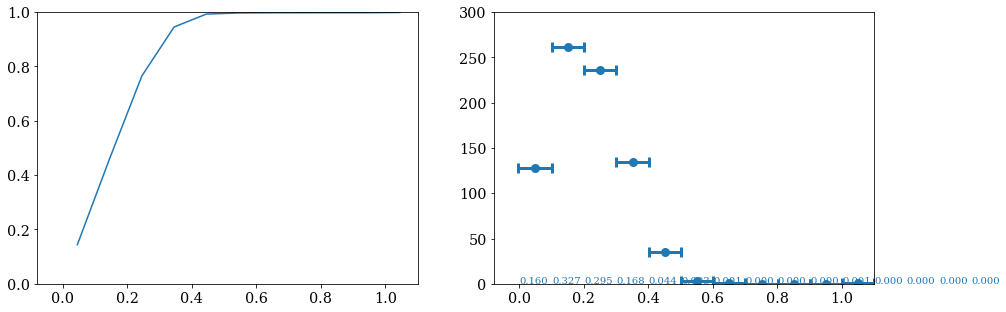

In [552]:
plt.figure(figsize=(15,5))
mode='cumulative'
z_bin = np.arange(-0.005,1.151,0.1)
#z_bin =[-0.1,0.4]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)
plt.subplot(1,2,1)
plt.plot(x,y)
print(y)
plt.ylim(0,1)
plt.xlim(-0.08,1.1)

plt.subplot(1,2,2)
mode='differential'
z_bin = np.arange(0.001,1.56,0.1)
z_bin[0]=-0.003
#z_bin =[-0.002,0.001]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)

xerr = np.array(x)-z_bin[0:-1]
plt.errorbar(x,np.array(y)*1.0*800,xerr=xerr,ls='',capsize=5,mew=3,lw=3,marker='o',color='C0')
for i in range(0,len(x)):
    plt.text(x[i]-0.05,y[i]+0.05,'%0.3f' % y[i],color='C0')
    print('%0.4f' % y[i])
plt.ylim(0,300)
plt.xlim(-0.08,1.1)

In [553]:
1-np.sum(y)

0.0017010609248400144

------------------------------------------------------------------
### ELGs

In [480]:
object_type ='ELG'
if object_type=='ELG':
    all_catalog = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-3.1.fits')
elif object_type == 'ELG_VI':
    all_catalog = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-3.1.fits')
    
catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)

Number of spectra in deep: 70044
Number of spectra in short: 8707


In [481]:
len(all_catalog)

1825382

In [482]:
final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
# ---------------------
# cut the catalog with the interested parameter region  
# Baseline sample
# ELG
#

selection = ( #(final_catalog['GFIB']<24.1) &
             (((final_catalog['best_z']>0.6) & 
             (final_catalog['best_z']<1.497)) | ((final_catalog['best_z']>1.501) & (final_catalog['best_z']<1.58))) 
            ) 
selection = (((final_catalog['best_z']>-0.01) & 
              (final_catalog['best_z']<3.5)))
            # | ((final_catalog['best_z']>1.501) & (final_catalog['best_z']<1.55)) 
            #) 

base_line_catalog = final_catalog[selection]
SV3_selection = ((base_line_catalog['GTOT']>20) &
                 (base_line_catalog['GFIB']<24.1) &
                 (base_line_catalog['RZ']>0.15) & 
                 (base_line_catalog['GR']<0.1+0.5*base_line_catalog['RZ']) &
                 (base_line_catalog['GR']<-1.2*base_line_catalog['RZ']+1.3)
                )
base_line_catalog_SV3 = base_line_catalog[SV3_selection]
print('Number of spectra in the baseline catalog:',len(base_line_catalog))
print('Number of spectra in the SV3 catalog:',len(base_line_catalog_SV3))

Number of spectra in the matched catalog: 8707
Number of spectra in the baseline catalog: 8668
Number of spectra in the SV3 catalog: 2331


1880
0
451


(-1.0, 5.0)

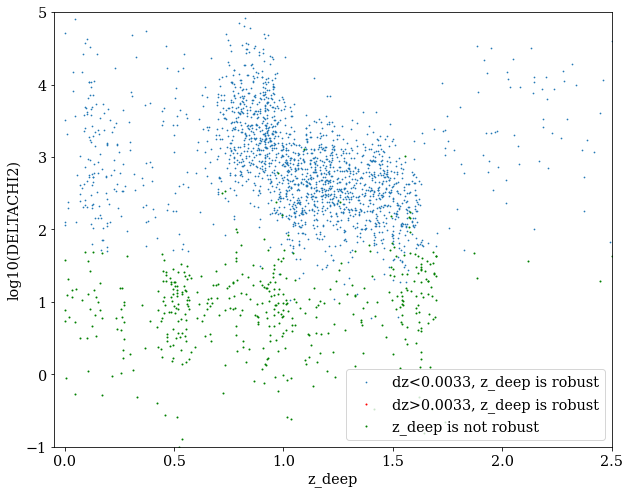

In [483]:
plt.figure(figsize=(10,8))
selection = (base_line_catalog_SV3['best_quality']>=2.5)  & (base_line_catalog_SV3['dz']<0.0033)
selection_2 = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']>0.0033) #& (base_line_catalog_SV3['DELTACHI2']>15)
selection_3 = (base_line_catalog_SV3['best_quality']<2.5)# & (base_line_catalog_SV3['dz']>0.0033)

plt.scatter(base_line_catalog_SV3['best_z'][selection],np.log10(base_line_catalog_SV3['DELTACHI2'][selection]),s=0.5,label="dz<0.0033, z_deep is robust")
                #c=base_line_catalog_SV3['zfibermag'][selection],vmin=19.0,vmax=21.5,)

plt.scatter(base_line_catalog_SV3['best_z'][selection_2],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_2]),s=1,label="dz>0.0033, z_deep is robust",color='r')
plt.scatter(base_line_catalog_SV3['best_z'][selection_3],np.log10(base_line_catalog_SV3['DELTACHI2'][selection_3]),s=1,label="z_deep is not robust",color='g')
print(len(base_line_catalog_SV3[selection]))
print(len(base_line_catalog_SV3[selection_2]))
plt.legend()
plt.ylabel('log10(DELTACHI2)')
plt.xlabel('z_deep')
#plt.axhline(np.log10(40),ls='--',color='grey')
print(len(base_line_catalog_SV3[selection_3]))
plt.xlim(-0.05,2.5)
plt.ylim(-1,5)

[0.01287001287001287, 0.045474045474045474, 0.057057057057057055, 0.06606606606606606, 0.07207207207207207, 0.08236808236808237, 0.09266409266409266, 0.14457314457314457, 0.2308022308022308, 0.3341913341913342, 0.42299442299442297, 0.5070785070785071, 0.583011583011583, 0.6396396396396397, 0.7095667095667095, 0.7593307593307593, 0.7752037752037753, 0.7803517803517803, 0.782925782925783, 0.788073788073788, 0.7923637923637924]
0.0017
0.0807
0.3441
0.3376
0.0425


(-0.08, 3.1)

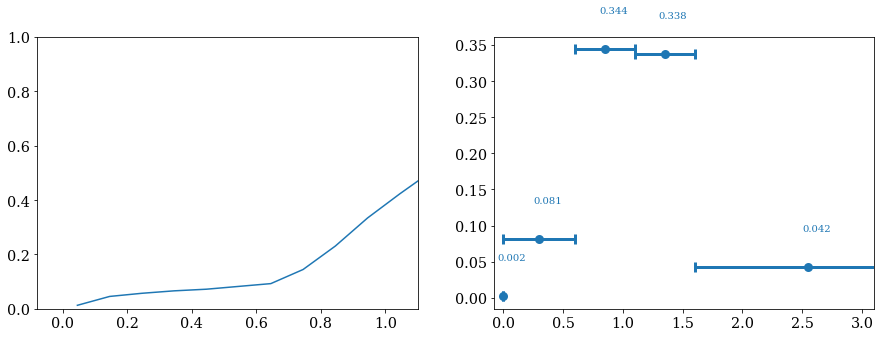

In [486]:
plt.figure(figsize=(15,5))
mode='cumulative'
z_bin = np.arange(-0.005,2.151,0.1)
#z_bin =[-0.1,0.4]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)
plt.subplot(1,2,1)
plt.plot(x,y)
print(y)
plt.ylim(0,1)
plt.xlim(-0.08,1.1)

plt.subplot(1,2,2)
mode='differential'
z_bin = np.arange(0.001,3.56,0.1)
#z_bin[0]=-0.003
z_bin =[-0.002,0.001,0.6,1.1,1.6,3.5]
x,y = getting_completeness_and_failure_rate_as_a_function_of_z(base_line_catalog_SV3,mode,z_bin,object_type)

xerr = np.array(x)-z_bin[0:-1]
plt.errorbar(x,np.array(y)*1.0,xerr=xerr,ls='',capsize=5,mew=3,lw=3,marker='o',color='C0')
for i in range(0,len(x)):
    plt.text(x[i]-0.05,y[i]+0.05,'%0.3f' % y[i],color='C0')
    print('%0.4f' % y[i])
#plt.ylim(0,300)
plt.xlim(-0.08,3.1)

In [485]:
1-np.sum(y)

0.19519519519519513

[]

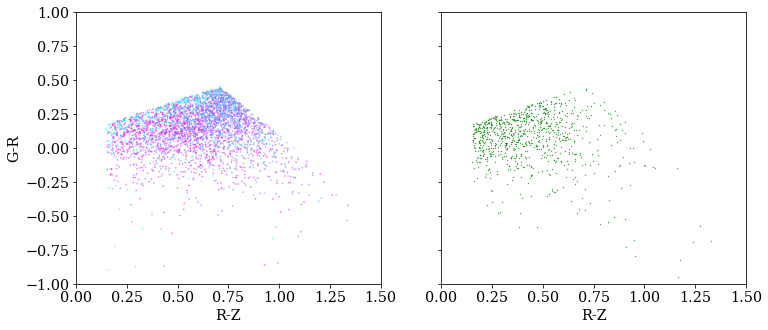

In [476]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(base_line_catalog_SV3['RZ'][base_line_catalog_SV3['best_quality']>=2.5],
            base_line_catalog_SV3['GR'][base_line_catalog_SV3['best_quality']>=2.5],s=0.5,
            c=base_line_catalog_SV3['best_z'][base_line_catalog_SV3['best_quality']>=2.5]
            ,vmin=0.6,vmax=1.5,cmap=cm.cool,alpha=0.5)
#plt.colorbar(orientation="horizontal")
plt.ylabel('G-R')
plt.xlabel('R-Z')
plt.xlim(0,1.5)
plt.ylim(-1,1)
plt.subplot(1,2,2)
plt.scatter(base_line_catalog_SV3['RZ'][base_line_catalog_SV3['best_quality']<2.5],
            base_line_catalog_SV3['GR'][base_line_catalog_SV3['best_quality']<2.5],s=0.1,c='g')
           #c=base_line_catalog_SV3['best_z'][base_line_catalog_SV3['best_quality']<2.5]
           # ,vmin=0.6,vmax=1.5,cmap=cm.cool,alpha=0.5)
#plt.axes.get_yaxis().set_visible(False)

plt.xlim(0,1.5)
plt.ylim(-1,1)
plt.xlabel('R-Z')
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])



(array([105., 178., 133., 303., 207.,  97.,  75., 153., 139., 298.]),
 array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]),
 <a list of 10 Patch objects>)

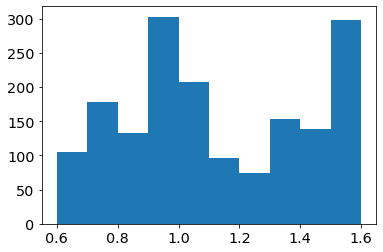

In [56]:
plt.hist(base_line_catalog_SV3['best_z'][base_line_catalog_SV3['best_quality']<2.5],bins=10,range=(0.6,1.6))

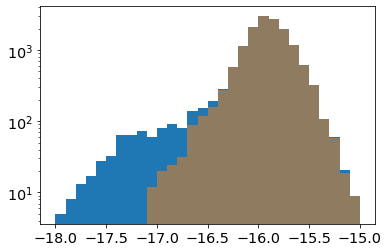

In [81]:

plt.hist(np.log10(base_line_catalog_SV3['FOII_deep']),bins=30,range=(-18,-15))
plt.hist(np.log10(base_line_catalog_SV3['FOII_deep'][(base_line_catalog_SV3['best_quality']>=2.5)]),bins=30,range=(-18,-15),alpha=0.5)
plt.yscale('log')
#plt.hist(np.log10(base_line_catalog_SV3['FOII'][(base_line_catalog_SV3['best_quality']>=2.5)]),bins=20,range=(-18,-15),alpha=0.5)

Text(0, 0.5, '[OII] Flux')

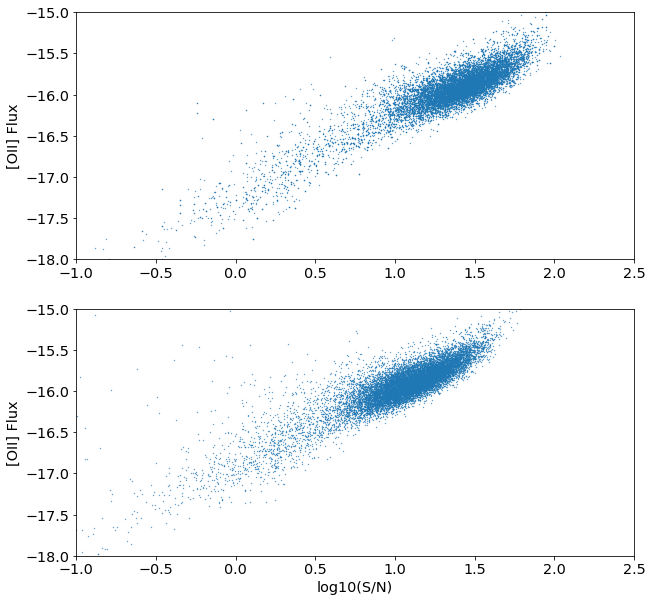

In [109]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(np.log10(base_line_catalog_SV3['OII_SN_deep']),np.log10(base_line_catalog_SV3['FOII_deep']),
            s=0.1,alpha=1)
plt.xlim(-1,2.5)
plt.ylim(-18,-15)
plt.ylabel('[OII] Flux')
plt.subplot(2,1,2)
plt.scatter(np.log10(base_line_catalog_SV3['OII_SN']),np.log10(base_line_catalog_SV3['FOII']),
            s=0.1,alpha=1)
plt.xlim(-1,2.5)
plt.ylim(-18,-15)
plt.xlabel('log10(S/N)')
plt.ylabel('[OII] Flux')
#plt.axvline(np.log10(5))
#plt.scatter(np.log10(base_line_catalog_SV3['OII_SN']),np.log10(base_line_catalog_SV3['FOII']),s=1,alpha=0.2)
#plt.xlim(-1,2.5)
#plt.ylim(-18,-14)
#plt.axvline(np.log10(5))

16140
13702
1688
750


Text(0.5, 1.0, '850<EFFTIME_DARK<950')

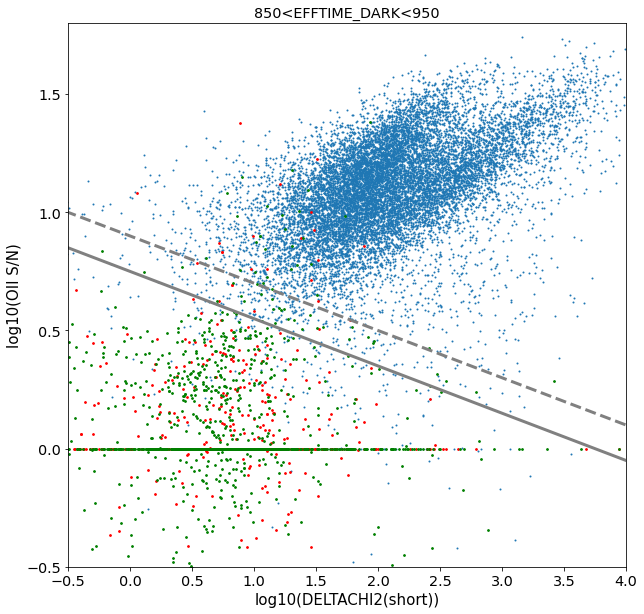

In [762]:
plt.figure(figsize=(10,10))
#plt.scatter(base_line_catalog['DELTA'],base_line_catalog['GR'],s=1)
good = (base_line_catalog_SV3['dz']<0.0033) & (base_line_catalog_SV3['best_quality']>=2.5)
bad = (base_line_catalog_SV3['best_quality']<2.5) # | (base_line_catalog_SV3['dz']>0.0033)
below = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']>0.0033) #& (np.log10(base_line_catalog_SV3['OII_SN'])>0.6-0.2*np.log10(base_line_catalog_SV3['DELTACHI2']))

print(len(base_line_catalog_SV3))
print(len(base_line_catalog_SV3['DELTACHI2'][good]))
print(len(base_line_catalog_SV3['DELTACHI2'][bad]))
print(len(base_line_catalog_SV3['DELTACHI2'][below]))
#below = 
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][good]),np.log10(base_line_catalog_SV3['OII_SN'][good]),s=1,label='dz<0.0033, z_deep is robust')
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][below]),np.log10(base_line_catalog_SV3['OII_SN'][below]),s=3,color='r',label='dz>0.0033, z_deep is robust')
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][bad]),np.log10(base_line_catalog_SV3['OII_SN'][bad]),s=3,color='g',label='z_deep is not robust')

x = np.arange(-1,5)
plt.plot(x,0.9-0.2*x,ls='--',color='grey',lw=3)
plt.plot(x,0.75-0.2*x,ls='-',color='grey',lw=3)
plt.xlim(-0.5,4)
plt.ylim(-0.5,1.8)
plt.xlabel('log10(DELTACHI2(short))',fontsize=15)
plt.ylabel('log10(OII S/N)',fontsize=15)
plt.title('850<EFFTIME_DARK<950')

In [631]:
magnitude_name = 'best_z'
mag_bin = np.arange(0.6,1.61,0.1)
if object_type == 'ELG':
    mode = 'differential'

    output_diff_ELG = plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)
    mode = 'cumulative'
    output_cum_ELG = plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)
    print('ELG')

ELG VI


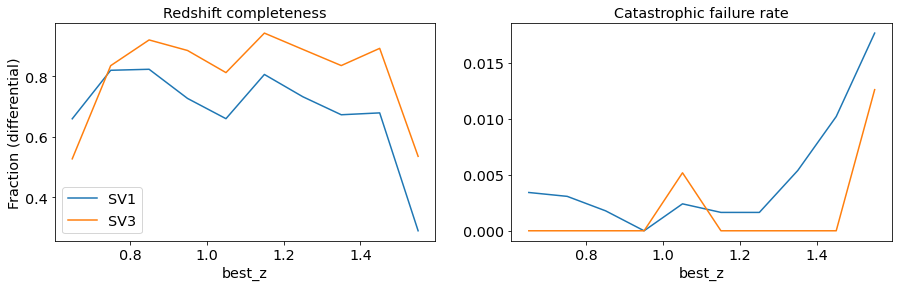

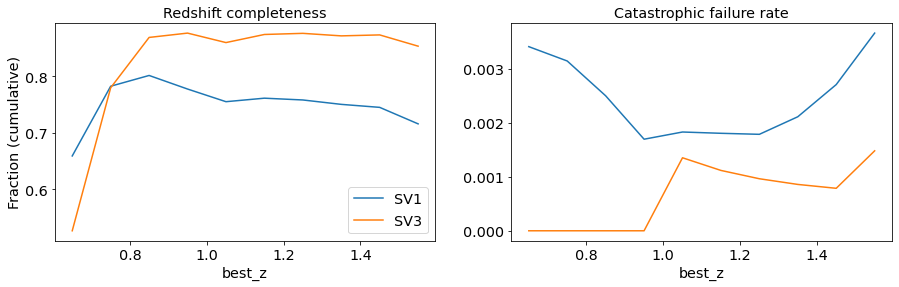

In [632]:
#mag_bin = np.arange(20.5,24.12,0.5)
if object_type == 'ELG_VI':
    mode = 'differential'
    output_diff_ELG_VI = plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)
    mode = 'cumulative'
    output_cum_ELG_VI = plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)    
    print('ELG VI')

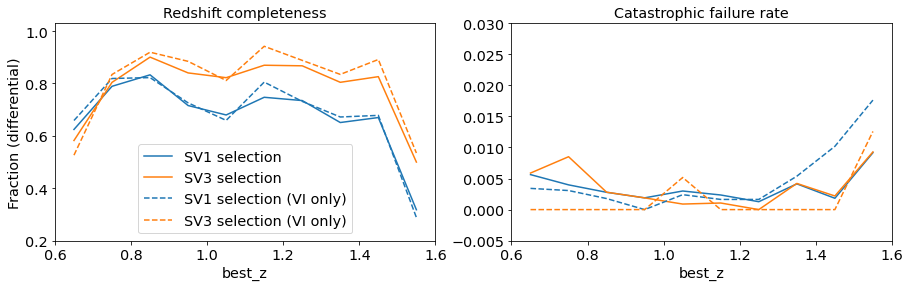

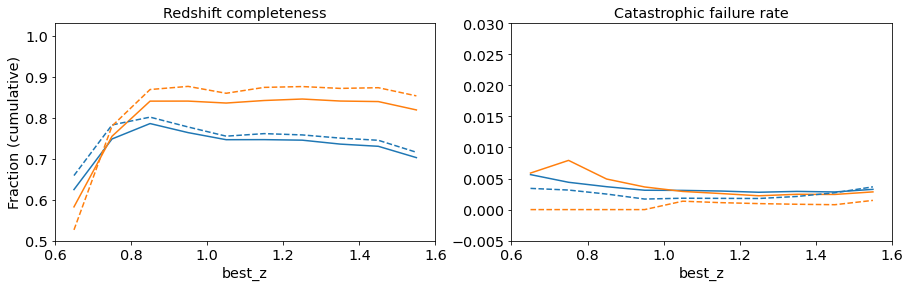

In [636]:
mode = 'differential'
plot_curve_VI_SV(output_diff_ELG,output_diff_ELG_VI,magnitude_name,mode)

mode = 'cumulative'
plot_curve_VI_SV(output_cum_ELG,output_cum_ELG_VI,magnitude_name,mode)

(-1.0, 5.0)

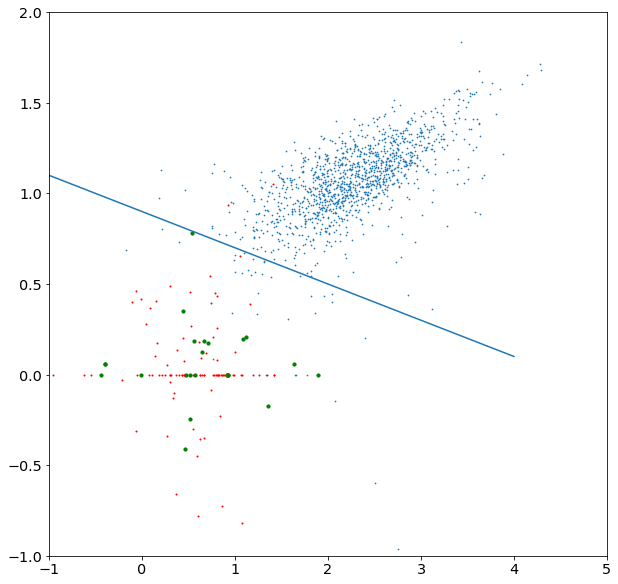

In [474]:
plt.figure(figsize=(10,10))
cut = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']<0.0033)
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][cut]),np.log10(base_line_catalog_SV3['OII_SN'][cut]),s=0.5,
            )
cut = (base_line_catalog_SV3['best_quality']>=2.5) & (base_line_catalog_SV3['dz']>0.0033)
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][cut]),np.log10(base_line_catalog_SV3['OII_SN'][cut]),s=10,color='g')
            #)
cut = (base_line_catalog_SV3['best_quality']<2.5) # | (base_line_catalog['dz']>0.0033) | (base_line_catalog['FOII']<0)
plt.scatter(np.log10(base_line_catalog_SV3['DELTACHI2'][cut]),np.log10(base_line_catalog_SV3['OII_SN'][cut]),s=1,color='r'
            )

#cut = (base_line_catalog['best_quality']!=4) & (base_line_catalog['dz']<0.0033)
#plt.scatter(np.log10(base_line_catalog['DELTACHI2'][cut]),np.log10(base_line_catalog['OII_SN'][cut]),s=1,color='purple'
            #)
x =np.arange(-1,5)
plt.plot(x,0.9-0.2*x)
plt.ylim(-1,2)
plt.xlim(-1,5)

In [475]:
len(base_line_catalog_SV3['DELTACHI2'][cut])

133

In [466]:
cut = (base_line_catalog['dz']<0.0033) #& (base_line_catalog['best_quality']==4)
print(len(base_line_catalog[cut]))
cut = (base_line_catalog['dz']<0.0033) & (base_line_catalog['best_quality']==4)
print(len(base_line_catalog[cut]))

17146
16675


In [883]:
cut = (base_line_catalog['dz']>0.0033)
print(len(base_line_catalog[cut]))

2937


0.9805373386926168

In [936]:
len(base_line_catalog_SV3)

15154

In [937]:
cut = (base_line_catalog_SV3['best_quality']==4) & (np.log10(base_line_catalog_SV3['OII_SN'])>0.9-0.2*np.log10(base_line_catalog_SV3['DELTACHI2']))
len(base_line_catalog_SV3[cut])

12732

(-1.0, 5.0)

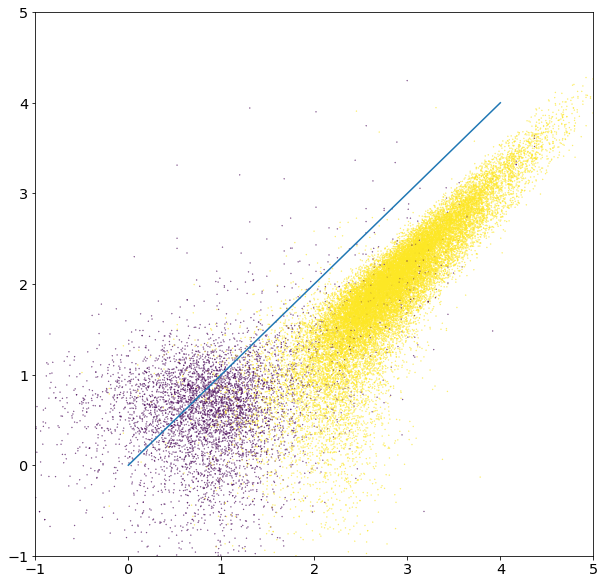

In [913]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(base_line_catalog['DELTACHI2_deep']),np.log10(base_line_catalog['DELTACHI2']),s=0.1,c=base_line_catalog['best_quality'])
plt.plot(np.arange(0,5),np.arange(0,5))
plt.xlim(-1,5)
plt.ylim(-1,5)

In [1367]:
base_line_catalog_SV3['FOII'][cut]

93      -9.999990e+03
163      2.952246e-15
250     -9.999990e+03
303     -9.999990e+03
307     -9.999990e+03
             ...     
48193   -9.999990e+03
48202   -9.999990e+03
48217   -4.236833e-17
48223    3.768249e-17
48401   -6.112508e-17
Name: FOII, Length: 712, dtype: float32

In [613]:
redshift_purity_matrix_SV = np.zeros((2,3,2))
redshift_purity_matrix_SV3 = np.zeros((2,3,2))

for i_data in range(0,2):
    if i_data==0:
        object_type ='ELG'
    else: 
        object_type ='ELG_VI'
    if object_type=='ELG':
        all_catalog = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-3.1.fits')
    elif object_type == 'ELG_VI':
        all_catalog = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-3.1.fits')

    catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)
    final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
    # ---------------------
    # cut the catalog with the interested parameter region  
    # Baseline sample
    # ELG
    #

    for i in range(0,3):
        if i ==0:
            selection = (((final_catalog['best_z']>0.6) & 
                     (final_catalog['best_z']<1.497)) | ((final_catalog['best_z']>1.501) & (final_catalog['best_z']<1.58)) 
                    ) 
        elif i==1:

            selection = (((final_catalog['best_z']>0.6) & 
                      (final_catalog['best_z']<1.1)))
                    # | ((final_catalog['best_z']>1.501) & (final_catalog['best_z']<1.55)) 
                    #) 
        elif i==2:
            selection = (((final_catalog['best_z']>1.1) & 
                 (final_catalog['best_z']<1.497)) | ((final_catalog['best_z']>1.501) & (final_catalog['best_z']<1.58)) 
                ) 
        base_line_catalog = final_catalog[selection]
        SV3_selection = ((base_line_catalog['GTOT']>20) &
                         (base_line_catalog['GFIB']<24.1) &
                         (base_line_catalog['RZ']>0.15) & 
                         (base_line_catalog['GR']<0.1+0.5*base_line_catalog['RZ']) &
                         (base_line_catalog['GR']<-1.2*base_line_catalog['RZ']+1.6))
        base_line_catalog_SV3 = base_line_catalog[SV3_selection]
        print('Number of spectra in the baseline catalog:',len(base_line_catalog))
        print('Number of spectra in the SV3 catalog:',len(base_line_catalog_SV3))
        redshift_purity_matrix_SV[i_data,i,0],redshift_purity_matrix_SV[i_data,i,1]=calculating_redshift_completeness_and_failure_rate(base_line_catalog,object_type,True)
        redshift_purity_matrix_SV3[i_data,i,0],redshift_purity_matrix_SV3[i_data,i,1]=calculating_redshift_completeness_and_failure_rate(base_line_catalog_SV3,object_type,True)
        

Number of spectra in deep: 70044
Number of spectra in short: 30497
Number of spectra in the matched catalog: 26763
Number of spectra in the baseline catalog: 18927
Number of spectra in the SV3 catalog: 8768
13653 5198 17 55 18927
0.7213504517356157 0.0038040893961008085
7277 1460 7 21 8768
0.8299498175182481 0.0031934306569343066
Number of spectra in the baseline catalog: 11185
Number of spectra in the SV3 catalog: 4728
8527 2605 11 40 11185
0.7623603039785427 0.004559678140366562
3984 725 5 12 4728
0.8426395939086294 0.0035956006768189507
Number of spectra in the baseline catalog: 7742
Number of spectra in the SV3 catalog: 4040
5126 2593 6 15 7742
0.6621028158098683 0.0027124773960217
3293 735 2 9 4040
0.81509900990099 0.0027227722772277226
Number of spectra in deep: 10315
Number of spectra in short: 6449
Number of spectra in the matched catalog: 6449
Number of spectra in the baseline catalog: 4774
Number of spectra in the SV3 catalog: 1807
3420 1330 7 14 4774
0.7163803937997486 0.004

([<matplotlib.axis.XTick at 0x2aaae3f3df70>,
 [Text(0, 0, '$0.6<z<1.58$'),
  Text(0, 0, '$0.6<z<1.1$'),
  Text(0, 0, '$1.1<z<1.58$')])

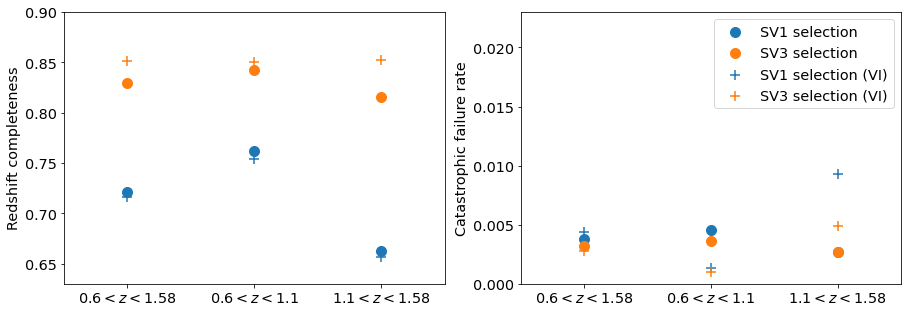

In [615]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter([1,2,3],redshift_purity_matrix_SV[0,:,0],s=100)
plt.scatter([1,2,3],redshift_purity_matrix_SV3[0,:,0],s=100)
plt.scatter([1,2,3],redshift_purity_matrix_SV[1,:,0],s=100,color='C0',marker='+')
plt.scatter([1,2,3],redshift_purity_matrix_SV3[1,:,0],s=100,color='C1',marker='+')

plt.ylabel('Redshift completeness')
plt.xlim(0.5,3.5)
plt.xticks([1,2,3],('$0.6<z<1.58$','$0.6<z<1.1$','$1.1<z<1.58$'))
plt.ylim(0.63,0.9)
plt.subplot(1,2,2)
plt.scatter([1,2,3],redshift_purity_matrix_SV[0,:,1],s=100,label='SV1 selection')
plt.scatter([1,2,3],redshift_purity_matrix_SV3[0,:,1],s=100,label='SV3 selection')
plt.scatter([1,2,3],redshift_purity_matrix_SV[1,:,1],s=100,color='C0',marker='+',label='SV1 selection (VI)')
plt.scatter([1,2,3],redshift_purity_matrix_SV3[1,:,1],s=100,color='C1',marker='+',label='SV3 selection (VI)')
plt.legend()
plt.ylim(0,0.023)
plt.ylabel('Catastrophic failure rate')
plt.xlim(0.5,3.5)
plt.xticks([1,2,3],('$0.6<z<1.58$','$0.6<z<1.1$','$1.1<z<1.58$'))